In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

# Get the speed of creating files in parallel
def get_creates(fname):
    with open(fname) as f:
        df = pd.read_csv(f, names=['job', 'nfiles', 'time', 'runtime'])
        df['runtime'] = df['runtime'].apply(to_seconds)
    df = df[df['job'] == 'create']
    df = df[df['nfiles'] == 100000]    
    return df

def get_means(runs):
    for run in runs:
        d = pd.read_csv("../results-run"+str(run)+"/summary.txt", names=csvhead)
        if run == 0: df = d
        df['tput-run'+str(run)] = nfiles/(d['runtime'].apply(to_seconds))
        df['tput-create-run'+str(run)] = nfiles/(d['runtime'].apply(to_seconds) + float(df_create['runtime']))
    df['merge'] =               df[['tput-run' + str(r) for r in runs]].mean(axis=1)
    df['merge_stds'] =          df[['tput-run' + str(r) for r in runs]].std(axis=1)
    df['merge+\ncreate'] =      df[['tput-create-run' + str(r) for r in runs]].mean(axis=1)
    df['merge+\ncreate_stds'] = df[['tput-create-run' + str(r) for r in runs]].std(axis=1)
    return df

def get_RPC_means():
    mean = pd.DataFrame(columns=["# of Clients", "isolated"])
    for i in nclient:    
        if i < 20:
            j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients" + str(i) + "/*isolated*"))
            norm = i*100000        
        else: # the max value we can scale to is 18
            if i == 20:
                j1 = parse_mdtest(glob.glob("../../baseline-creates/results-cloudlab-clients18/*isolated*"))
                norm = 18*100000 
            else: 
                j1 = 0; norm = 1
        mean.loc[len(mean)] = [i, norm/np.mean(j1)]
    return mean

def fmt(labels):
    for i in range(0, len(labels)):
        if i % 2 == 1:
            labels[i] = ""
    labels[0] = ""
    return labels

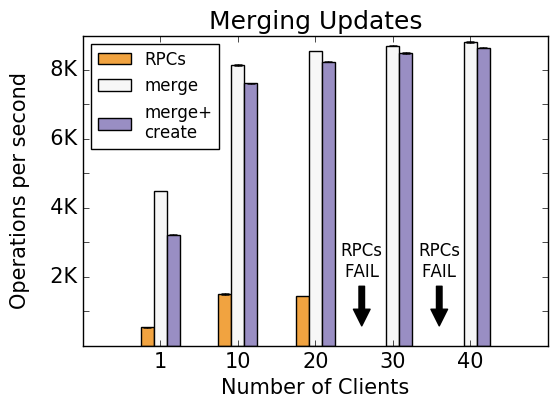

In [3]:
csvhead = ['job', 'nfiles', '# of Clients', 'time', 'runtime']
nclient = [40, 30, 20, 10, 1]
nfiles  = [c*100000 for c in nclient]
runs    = [0, 1, 2]
plt_val = ['RPCs', 'merge', 'merge+\ncreate']
plt_std = ['merge_stds', 'merge_stds', 'merge+\ncreate_stds']
colors  = ['#f1a340', '#f7f7f7', '#998ec3']

df_create = get_creates('../../cudele-mechanisms/results/summary.txt')
rpc_means = get_RPC_means()
all_means = get_means(runs)
all_means['RPCs'] = rpc_means['isolated']
all_means = all_means.iloc[::-1]

# plot and draw arrows
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig, ax = plt.subplots(1, 1)
all_means[plt_val].plot.bar(ax=ax, yerr=all_means[plt_std].values.T, colors=colors)
args = {'horizontalalignment': 'center', 'fontsize': 12, 'arrowprops': dict(facecolor='black', shrink=0.05)}
ax.annotate('RPCs\nFAIL', xy=(2.6, 500), xytext=(2.6, 2000), **args)
ax.annotate('RPCs\nFAIL', xy=(3.6, 500), xytext=(3.6, 2000), **args)

# format!
ax.set_title("Merging Updates")
ax.set_xlabel("Number of Clients")
ax.set_xlim(-1, 5)
ax.set_xticklabels(all_means['# of Clients'], rotation=0)
ax.set_ylabel("Operations per second")
ax.set_yticklabels(fmt(['{:3.0f}K'.format(x/1000) for x in ax.get_yticks()]))
ax.legend(loc='upper left', fontsize=12)
fig.savefig('../../../paper/graphs/mergescale.png', bbox_inches='tight', dpi=400)